In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as dsfh
import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
#import statsmodels.api as sm #statsmodels is used for creating linear regression models
from sklearn.model_selection import train_test_split #creating testing and training data
from sklearn.metrics import roc_auc_score #evaluate model performance
import predhelp as ph

In [2]:
gdp = ph.gdp_clean("../data/gdpPC.csv")
exchange_rate = pd.read_csv("../data/cleaned data/exchangerate.csv")
PPI = pd.read_csv("../data/cleaned data/PPI.csv")
unemployment = pd.read_csv("../data/cleaned data/unemployment1.csv")
regions = ["Saanen"]
df_final, all_regions = ph.dict_clean("../data/px-x-1003020000_101.px", regions)

/usr/local/Caskroom/miniconda/base/envs/dsf/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/boasnydegger/Desktop/github/dsfgp/code/predhelp.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_regions[i][regions[i]].rename(columns = {'Jahr' : 'year', 'Monat': 'month'}, inplace = True)
/Users/boasnydegger/Desktop/github/dsfgp/code/predhelp.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_regions[i][regions[i]]['DATE'] = pd.to_datetime(

In [15]:
saanen = df_final[0]["Saanen"]

exchange_rate

,Unnamed: 0,ARS1_exrate,AUD1_exrate,BRL100_exrate,CAD1_exrate,CNY100_exrate,CZK100_exrate,DKK100_exrate,EUR1_exrate,GBP1_exrate,...,NZD1_exrate,PLN100_exrate,RUB1_exrate,SEK100_exrate,SGD1_exrate,THB100_exrate,TRY100_exrate,USD1_exrate,ZAR1_exrate,DATE
0,0,18.67700,0.97002,45.46090,0.93180,14.70635,4.81060,16.45610,1.22800,1.47680,...,0.77340,29.67480,0.03060,14.23780,0.75240,3.07180,52.14739,0.92410,0.10530,2013-01-01
1,1,18.37300,0.94904,46.56500,0.91240,14.66380,4.82820,16.48350,1.22980,1.42480,...,0.77190,29.47550,0.03050,14.45250,0.74300,3.08490,51.78650,0.92020,0.10340,2013-02-01
2,2,18.60100,0.97811,47.63330,0.92320,15.08571,4.78020,16.44900,1.22640,1.42700,...,0.78340,29.51190,0.03070,14.69380,0.75900,3.20530,52.27762,0.94600,0.10290,2013-03-01
3,3,18.20450,0.97392,46.77730,0.92040,14.99827,4.71990,16.36140,1.21980,1.43470,...,0.79470,29.46180,0.02990,14.45320,0.75750,3.22270,52.15591,0.93770,0.10290,2013-04-01
4,4,18.23960,0.94584,46.93910,0.93580,15.42609,4.79120,16.64520,1.24060,1.46110,...,0.78750,29.67910,0.03050,14.46650,0.76490,3.20760,52.30783,0.95500,0.10220,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,0.00834,0.69113,19.73513,0.76282,14.63506,4.18452,13.92306,1.03591,1.21942,...,0.62740,22.26913,0.01523,9.87572,0.70881,2.84735,6.29130,0.98024,0.06161,2022-05-01
113,113,0.00791,0.68082,19.23460,0.75647,14.47895,4.14539,13.77732,1.02495,1.19485,...,0.61565,22.05405,0.01703,9.66685,0.70067,2.77386,5.69668,0.96962,0.06138,2022-06-01
114,114,0.00757,0.66437,18.04921,0.74919,14.40007,4.01505,13.27070,0.98765,1.16254,...,0.60063,20.69005,0.01642,9.33381,0.69464,2.66648,5.54941,0.96954,0.05752,2022-07-01
115,115,0.00709,0.66613,18.61382,0.74116,14.06791,3.94514,13.02530,0.96899,1.14693,...,0.59962,20.52874,0.01576,9.21974,0.69142,2.67159,5.30527,0.95717,0.05734,2022-08-01


In [33]:
total_df = pd.concat([saanen, gdp, exchange_rate, PPI, unemployment], axis=1, verify_integrity=False, copy=False).drop_duplicates()
total_df = total_df.loc[:,~total_df.columns.duplicated()].copy()

<AxesSubplot:>

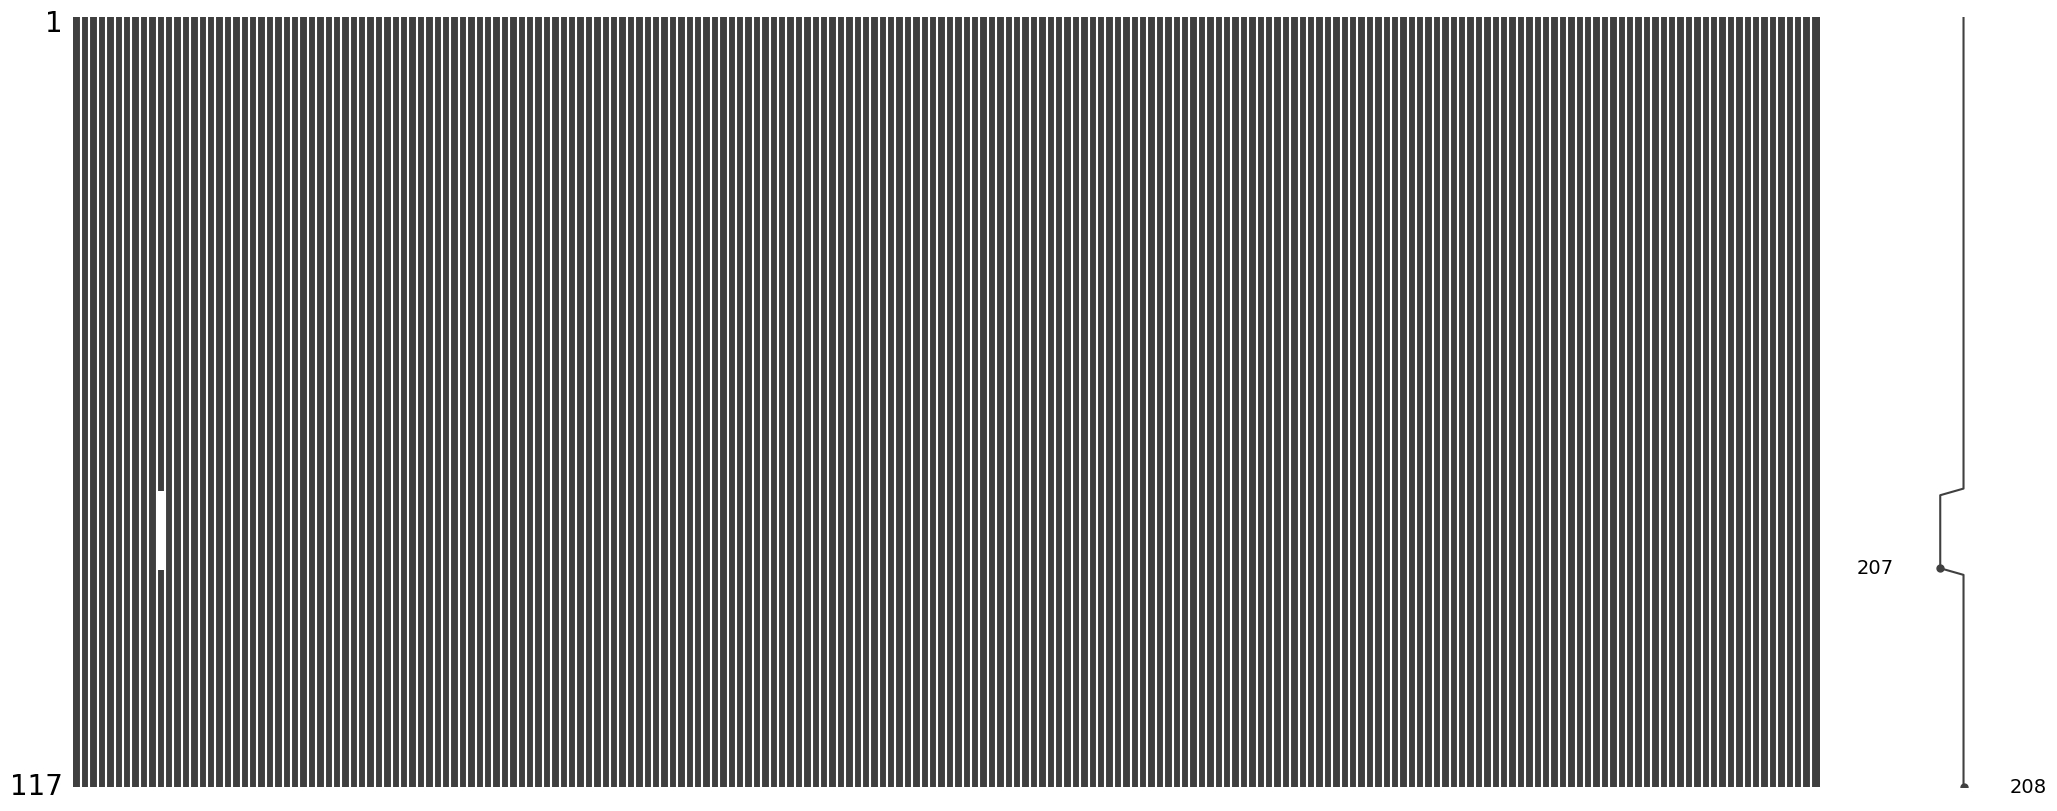

In [40]:
msno.matrix(total_df)

In [43]:
columnlistnames = total_df.columns.tolist()

<AxesSubplot:>

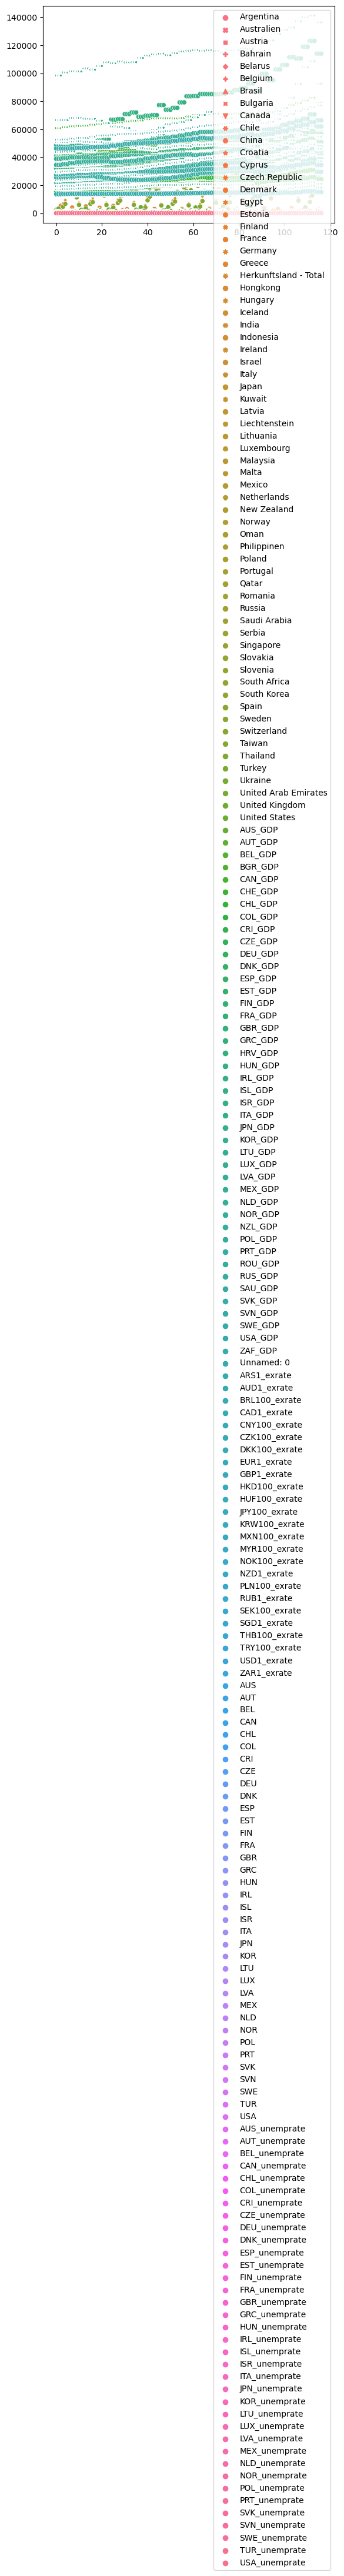

In [63]:
total_df["Chile"].sum()/214
sns.scatterplot(total_df[])

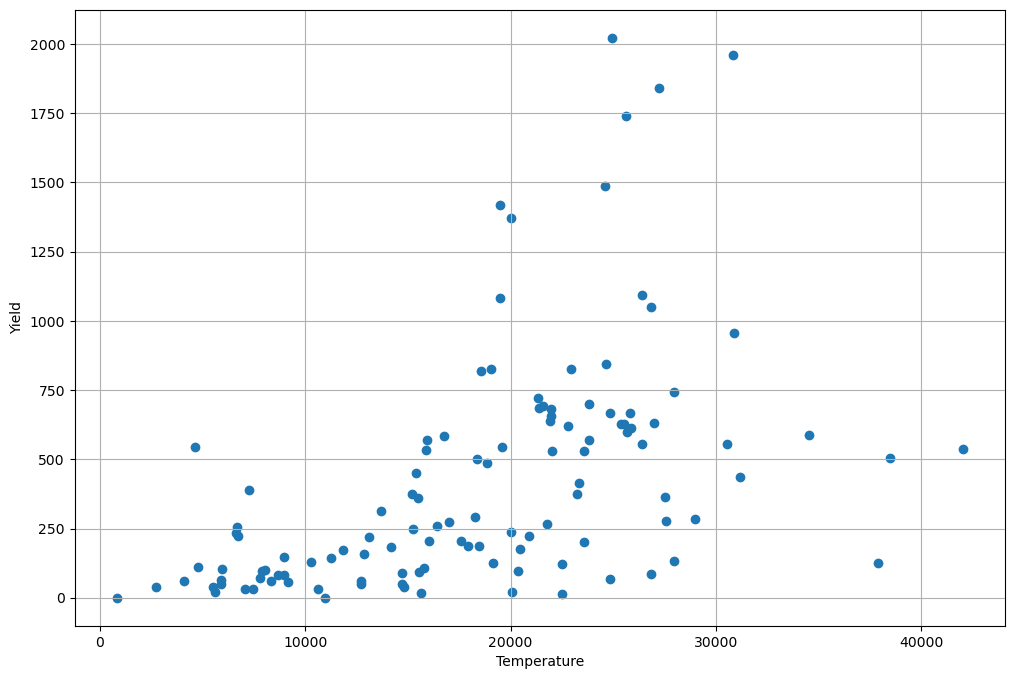

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(total_df["Herkunf"], total_df["Belgium"])
# Label axes
ax.set_xlabel("Temperature")
ax.set_ylabel("Yield")
# Add a grid
ax.grid(True)

In [51]:
total_df

,DATE,Argentina,Australien,Austria,Bahrain,Belarus,Belgium,Brasil,Bulgaria,Canada,...,MEX_unemprate,NLD_unemprate,NOR_unemprate,POL_unemprate,PRT_unemprate,SVK_unemprate,SVN_unemprate,SWE_unemprate,TUR_unemprate,USA_unemprate
0,2013-01-01,8.0,218.0,98.0,10.0,32.0,721.0,331.0,9.0,159.0,...,5.208234,7.5,3.8,10.8,18.3,14.2,10.2,8.1,8.8,8.0
1,2013-02-01,12.0,13.0,180.0,21.0,2.0,2023.0,323.0,176.0,82.0,...,4.848728,7.7,4.0,10.9,18.2,14.2,10.6,8.2,8.8,7.7
2,2013-03-01,14.0,18.0,37.0,10.0,0.0,819.0,77.0,8.0,58.0,...,4.907551,7.9,4.1,10.9,18.1,14.2,10.8,8.5,9.0,7.5
3,2013-04-01,4.0,34.0,5.0,14.0,0.0,545.0,16.0,0.0,2.0,...,5.144341,8.0,4.1,11.0,17.9,14.2,10.8,8.4,9.1,7.6
4,2013-05-01,0.0,17.0,20.0,0.0,375.0,233.0,6.0,0.0,24.0,...,5.085738,8.1,3.9,10.9,17.7,14.2,10.6,8.0,9.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2022-05-01,0.0,10.0,32.0,0.0,0.0,60.0,13.0,3.0,36.0,...,3.365771,3.3,3.8,2.7,6.0,6.2,4.5,7.7,10.7,3.6
113,2022-06-01,11.0,36.0,192.0,9.0,2.0,175.0,13.0,0.0,97.0,...,3.330639,3.4,3.0,2.7,6.0,6.1,4.4,7.6,10.4,3.6
114,2022-07-01,31.0,271.0,156.0,62.0,2.0,555.0,240.0,18.0,276.0,...,3.261059,3.6,2.8,2.6,6.0,6.0,4.2,7.0,10.2,3.5
115,2022-08-01,68.0,131.0,123.0,32.0,8.0,365.0,106.0,9.0,121.0,...,3.262605,3.8,3.5,2.6,6.0,5.9,4.1,6.9,9.8,3.7
